## Download restaurant data from Yelp API

Script learned and followed from https://www.youtube.com/watch?v=0ktyc_PLWUg&ab_channel=SpencerHolley

In [10]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# essential arguments used to send api requests
url = 'https://api.yelp.com/v3/businesses/search'
api_key = 'vevbYbYiuM0heHFrfYU_WiiPPqS-8VjcXHniGbE-01pS1mj-Lw__O_NZN4Injj3nPbSArkJufV3WIWhDQXmzogHenrBXMJ0ZP8wQ3jfBaZvT7fsXCo87I5Iyr9loYnYx'
headers = {'Authorization': 'Bearer %s' % api_key}


In [14]:
# list of original categories available on Yelp
categories = ['italian','french','spanish','portuguese','austrian','belgian','bulgarian','czech','georgian','german','hungarian',
              'fondue','polish','scandinavian','african','ethiopian','moroccan','mediterranean','greek','kebab','turkish','arabian',
              'pakistani','mideastern','afghani','australian','russian','ukrainian','chinese','taiwanese','indpak','cambodian','indonesian',
              'laotian','malaysian','singaporean','srilankan','thai','vietnamese','japanese','korean','bangladeshi','burmese','filipino',
              'himalayan','asianfusion','mongolian','newamerican','tradamerican','hawaiian','mexican','argentine','brazilian','caribbean',
              'cuban','latin','peruvian']

In [15]:
general_cate = [{'Italian':['italian']},
               {'French':['french']},
               {'Mediterranean':['mediterranean', 'greek']},
               {'Spanish':['spanish','portuguese']},
               {'Central_European':['austrian','belgian','german','scandinavian','czech','fondue']},
               {'East_European_&_Balkans':['hungarian','polish','russian','georgian','bulgarian','ukrainian']},
               {'African':['african','ethiopian']},
               {'Middle_Eastern':['mideastern','turkish','kebab','moroccan','arabian','afghani']},
               {'South_Asian':['pakistani','indpak','srilankan','himalayan','bangladeshi']},
               {'North_American':['australian', 'newamerican','tradamerican','hawaiian']},
               {'East_Asian':['chinese', 'taiwanese','japanese','korean','asianfusion']},
               {'Southeast_Asian':['indonesian', 'malaysian','thai','vietnamese','burmese','filipino','singaporean','laotian']},
               {'Latin_American':['mexican','caribbean','latin', 'brazilian', 'argentine', 'peruvian', 'cuban']}
               ]

In [16]:
# a csv containing the info to define search areas (processed from the London boroughs shapefile in ArcGIS)
centroids = pd.read_csv("centroids.csv")

In [17]:
# create a list of search area parameters
c_x = centroids.centroid_x.tolist()
c_y = centroids.centroid_y.tolist()
mbg_r = centroids.radius.tolist()
search_areas = []
for i in range(33):
    search_para = dict(longitude=c_x[i],latitude=c_y[i],radius=int(mbg_r[i]))
    search_areas.append(search_para)

In [18]:
# a series of functions used to retrieve and convert data
def search_area(offset,category,search_range):
    # return the list of businesses of certain category (string) in the specified search area (dictionary)
    
    params = {'term':'restaurants','locale':'en_GB','limit':50,'offset':offset,'categories':category}
    params.update(search_range)
    req=requests.get(url, params=params, headers=headers)
    return req.json()['businesses']

def business_retriever(category,search_range):
    # retrive the json data of a certian cusine category in the specified area and store as a list
    
    cate_results = []
    
    # test number of total restaurants in this category
    params = {'term':'restaurants','locale':'en_GB','limit':1,'offset':0,'categories':category}
    params.update(search_range)
    req=requests.get(url, params=params, headers=headers)
    
    if req.status_code == 200: # proceed only if the status code is 200
        total = req.json()['total']
        if total > 1000:
            print ('There are more than 1000 restaurants under category',category,'. Only the first 1000 will be returned.')
            for offset in range(0,1000,50):
                results = search_area(offset,category,search_range)
                cate_results.extend(results)
        elif total > 50 and total <= 1000:
            for offset in range(0,total,50):
                results = search_area(offset,category,search_range)
                cate_results.extend(results)
        else:
            cate_results.extend(search_area(0,category,search_range))
            
    else:
        print ('Error in retrieving data.')
        
    return cate_results

def extractor(categories,search_range):
    # extract useful info from data retrieved and combine restaurants of different categories into one list
    full_restaurants = []
    for category in categories: # loop through all the categories
        results = business_retriever(category,search_range)
        for restaurant in results: # loop through restaurants in each category
            if restaurant['is_closed'] == False: # only keep records that are still open
                rest_out = {}
                rest_out['id'] = restaurant['id']
                rest_out['category'] = category
                rest_out['longitude'] = restaurant['coordinates']['longitude']
                rest_out['latitude'] = restaurant['coordinates']['latitude']
                full_restaurants.append(rest_out)
    return full_restaurants

In [ ]:
# loop through the search areas, extract restaurant information and combine them together
rest_list = []
for area in search_areas:
    resta_area = extractor(categories,area)
    rest_list.extend(resta_area)


In [12]:
# transform the list to a dataframe
rest_df = pd.DataFrame(rest_list)
# remove the duplicates
final_df = rest_df.drop_duplicates(subset='id')

In [ ]:
# a new column was added to the dataframe and the general category of each entry was assigned
final_df.loc[:,'general_category'] = np.nan
for dicts in general_cate:
    for small_cate in list(dicts.values())[0]:
        final_df.loc[final_df.category == small_cate,['general_category']] = list(dicts.keys())[0]

In [12]:
final_df.to_csv("restaurants.csv")

## Create a summary plot for all restauranta retrieved

In [7]:
all_cat = ['East_Asian','Italian','South_Asian','Middle_Eastern','Southeast_Asian','Latin_American',
           'Mediterranean','North_American','French','Spanish','African','Central_European','East_European']

all_val = [1677,1613,1597,687,622,510,462,380,360,223,113,56,54]

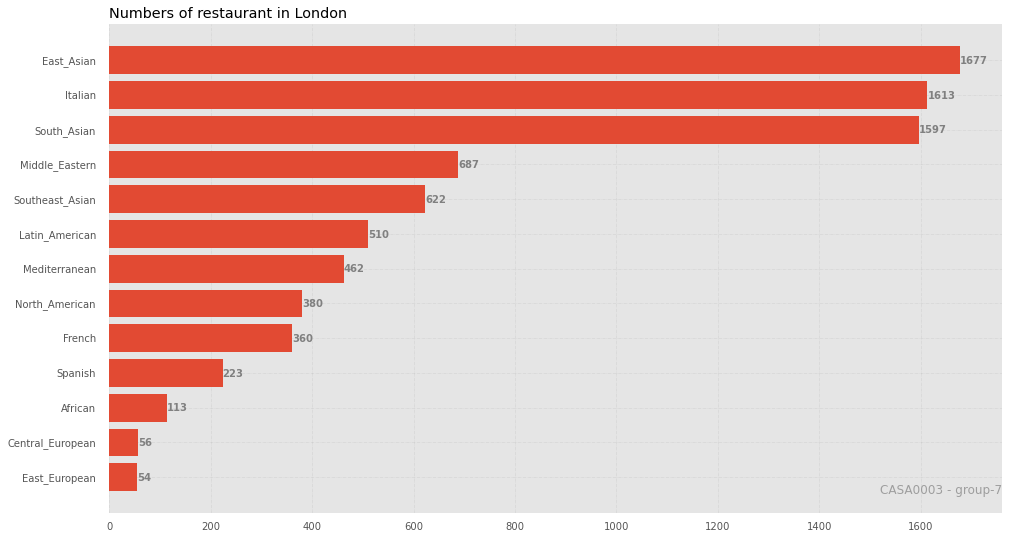

In [10]:
name = all_cat
price = all_val
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(name, price)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Numbers of restaurant in London',
             loc ='left', )
 
# Add Text watermark
fig.text(0.9, 0.15, 'CASA0003 - group-7', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)
 
# Show Plot
plt.show()